In [18]:
import os
import shutil
import tarfile
import numpy as np
# import librosa
# import librosa.feature
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import sys

2025-06-23 04:59:33.514759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750647573.529568  235909 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750647573.534518  235909 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 04:59:33.549756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
DATASET_URL = "http://www.openslr.org/resources/12/train-clean-100.tar.gz"
TAR_FILENAME = "train-clean-100.tar.gz"
DATA_DIR = './data'
EXTRACT_PATH = os.path.join(DATA_DIR, 'train-clean-100_extracted', 'LibriSpeech', 'train-clean-100')

MAX_AUDIO_LEN_S = 10.0
SEGMENT_LEN_S = 2.0
SAMPLE_RATE = 16000
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

In [3]:
def download_and_extract_data():
    if os.path.exists(EXTRACT_PATH):
        print("Dataset is already unzipped")
        return

    os.makedirs(DATA_DIR, exist_ok=True)

    tf.keras.utils.get_file(
        fname=TAR_FILENAME,
        origin=DATASET_URL,
        cache_dir=DATA_DIR,
        cache_subdir='',
        extract=True,
        archive_format='tar'
    )

    print("Download is complete")

In [5]:
def analyze_dataset():
    if not os.path.exists(EXTRACT_PATH):
        print(f"Folder {EXTRACT_PATH} does not exists")
        return

    speaker_dirs = [d for d in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, d))]

    speaker_stats = {}
    total_files = 0

    for speaker_id in speaker_dirs:
        speaker_path = os.path.join(EXTRACT_PATH, speaker_id)
        print(f"Analyzing : {speaker_id}")
        for root, _, files in os.walk(speaker_path):
            flac_files = [f for f in files if f.endswith(".flac")]
            if speaker_id not in speaker_stats:
                speaker_stats[speaker_id] = {'count': 0, 'durations': []}

            speaker_stats[speaker_id]['count'] += len(flac_files)
            total_files += len(flac_files)

            for f in flac_files:
                file_path = os.path.join(root, f)
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                speaker_stats[speaker_id]['durations'].append(librosa.get_duration(y=y, sr=sr))

    num_speakers = len(speaker_stats)

    file_counts = [s['count'] for s in speaker_stats.values()]
    all_durations = [d for s in speaker_stats.values() for d in s['durations']]

    print("--- Analiza Podatkovne Zbirke ---")
    print(f"Število govorcev: {num_speakers}")
    print(f"Število vseh posnetkov: {total_files}")
    print("\nStatistika števila posnetkov na govorca:")
    print(f"  - Povprečje: {np.mean(file_counts):.2f}")
    print(f"  - Std odklon: {np.std(file_counts):.2f}")
    print(f"  - Minimum: {np.min(file_counts)}")
    print(f"  - Maksimum: {np.max(file_counts)}")

    print("\nStatistika dolžine posnetkov (s):")
    print(f"  - Povprečje: {np.mean(all_durations):.2f}")
    print(f"  - Std odklon: {np.std(all_durations):.2f}")
    print(f"  - Minimum: {np.min(all_durations):.2f}")
    print(f"  - Maksimum: {np.max(all_durations):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(file_counts, bins=30)
    plt.title("Porazdelitev št. posnetkov na govorca")
    plt.xlabel("Število posnetkov")
    plt.ylabel("Število govorcev")

    plt.subplot(1, 2, 2)
    sns.histplot(all_durations, bins=30)
    plt.title("Porazdelitev dolžin posnetkov")
    plt.xlabel("Dolžina (s)")
    plt.ylabel("Število posnetkov")
    plt.tight_layout()
    plt.show()

In [16]:
def load_data_from_h5(feature_model_path):
    if not os.path.exists(feature_model_path):
        raise Exception(f"Datoteka {feature_model_path} ne obstaja")

    with h5py.File(feature_model_path, 'r') as hf:
        X = np.array(hf.get('features'))
        y_str = np.array(hf.get('labels'))

    y_str = [label.decode('utf-8') for label in y_str]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_str)
    num_classes = len(label_encoder.classes_)
    y_categorical = to_categorical(y_encoded, num_classes=num_classes)

    X = X[..., np.newaxis]

    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    print(f"Velikost učne množice: {X_train.shape[0]}")
    print(f"Velikost validacijske množice: {X_val.shape[0]}")
    print(f"Velikost testne množice: {X_test.shape[0]}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder, num_classes

In [8]:
def process_and_save_features(num_speakers_to_process=100):
    path = os.path.join(DATA_DIR, f"speaker_data_{num_speakers_to_process}.h5")
    if os.path.exists(path):
        return

    features = []
    labels = []

    all_speaker_dirs = sorted([d for d in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, d))])
    speakers_to_process = all_speaker_dirs[:num_speakers_to_process]
    print(f"Obdelujem {len(speakers_to_process)} govorcev...")

    segment_len_samples = int(SEGMENT_LEN_S * SAMPLE_RATE)
    max_len_samples = int(MAX_AUDIO_LEN_S * SAMPLE_RATE)

    for speaker_id in speakers_to_process:
        speaker_path = os.path.join(EXTRACT_PATH, speaker_id)
        print(f"Obdelujem govorca: {speaker_id}")
        for root, _, files in os.walk(speaker_path):
            for f in files:
                if not f.endswith(".flac"):
                    continue

                file_path = os.path.join(root, f)
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                if len(y) > max_len_samples:
                    y = y[:max_len_samples]

                for start in range(0, len(y) - segment_len_samples + 1, segment_len_samples):
                    segment = y[start:start + segment_len_samples]
                    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                    features.append(mfcc)
                    labels.append(speaker_id)

    with h5py.File(path, 'w') as hf:
        hf.create_dataset('features', data=np.array(features, dtype=np.float32))
        labels_ascii = [n.encode("ascii", "ignore") for n in labels]
        hf.create_dataset('labels', data=np.array(labels_ascii))

    print(f"Končano. Shranjenih {len(features)} vzorcev.")

In [15]:
def plot_history(history, title_suffix=""):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"Metrike učenja - {title_suffix}", fontsize=16)

    axs[0].plot(history.history['accuracy'], label='Učna natančnost')
    axs[0].plot(history.history['val_accuracy'], label='Validacijska natančnost')
    axs[0].set_ylabel('Natančnost')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Natančnost med učenjem')

    axs[1].plot(history.history['loss'], label='Učna izguba')
    axs[1].plot(history.history['val_loss'], label='Validacijska izguba')
    axs[1].set_xlabel('Epohe')
    axs[1].set_ylabel('Izguba')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Izguba med učenjem')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [14]:
def add_noise(data, snr_db):
    data_noisy = np.copy(data)
    for i in range(len(data_noisy)):
        signal = data_noisy[i]
        signal_power = np.mean(signal ** 2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
        data_noisy[i] = signal + noise
    return data_noisy

In [13]:
def create_model(input_shape, num_classes, layers_config='base', size_config='base'):
    if size_config == 'smaller':
        filters = [16, 32]
        dense_units = 64
    elif size_config == 'larger':
        filters = [64, 128]
        dense_units = 256
    else:
        filters = [32, 64]
        dense_units = 128

    model = Sequential()
    model.add(Conv2D(filters[0], (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Konfiguracija arhitekture
    if layers_config == 'base' or layers_config == 'deep':
        model.add(Conv2D(filters[1], (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    if layers_config == 'deep':
        model.add(Conv2D(128, (3, 3), activation='relu'))  # Dodatna plast
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


    return model

In [22]:
def run_experiment(exp_title, model_config, noise_snr=None, feature_model_path=''):
    print(f"\n{'=' * 20} ZAČETEK EKSPERIMENTA: {exp_title} {'=' * 20}")

    (X_train, y_train), (X_val, y_val), (X_test, y_test), le, num_classes = load_data_from_h5(feature_model_path)
    if X_train is None:
        return
    input_shape = X_train.shape[1:]

    model_path = f'best_model_{exp_title}.h5'
    history = None  # So we can later check if model was trained now or loaded

    if not os.path.exists(model_path):
        print("Model ne obstaja, začnem učenje...")
        model = create_model(input_shape, num_classes, **model_config)
        print("\n--- Arhitektura modela ---")
        model.summary()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

        start_time = time.time()
        history = model.fit(X_train, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, model_checkpoint],
                            verbose=1)
        training_time = time.time() - start_time
        print(f"\nČas učenja: {training_time:.2f} sekund ({training_time / 60:.2f} minut)")
    else:
        print(f"Model že obstaja: {model_path}, nalagam ga...")

    best_model = load_model(model_path)

    # Priprava testnih podatkov (z morebitnim šumom)
    eval_X_test = X_test
    if noise_snr is not None:
        print(f"Dodajam šum na testno množico: SNR = {noise_snr} dB")
        eval_X_test = add_noise(X_test, noise_snr)

    test_loss, test_acc = best_model.evaluate(eval_X_test, y_test, verbose=0)
    print(f"\nRezultati na testni množici ({exp_title}):")
    print(f"  - Izguba: {test_loss:.4f}")
    print(f"  - Natančnost: {test_acc * 100:.2f}%")

    if history is not None:
        plot_history(history, exp_title)
    else:
        print("Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.")

    predictions = best_model.predict(eval_X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(12, 10))
    num_to_display = min(num_classes, 15)
    sns.heatmap(conf_matrix[:num_to_display, :num_to_display], annot=True, fmt='d',
                xticklabels=le.classes_[:num_to_display], yticklabels=le.classes_[:num_to_display])
    plt.title(f'Matrika zamešitev - {exp_title} (prvih {num_to_display} govorcev)')
    plt.xlabel('Predviden razred')
    plt.ylabel('Dejanski razred')
    plt.show()

--- Analiza Podatkovne Zbirke ---
Število govorcev: 251
Število vseh posnetkov: 28539

Statistika števila posnetkov na govorca:
  - Povprečje: 113.70
  - Std odklon: 15.18
  - Minimum: 26
  - Maksimum: 166

Statistika dolžine posnetkov (s):
  - Povprečje: 12.69
  - Std odklon: 3.57
  - Minimum: 1.41
  - Maksimum: 24.52


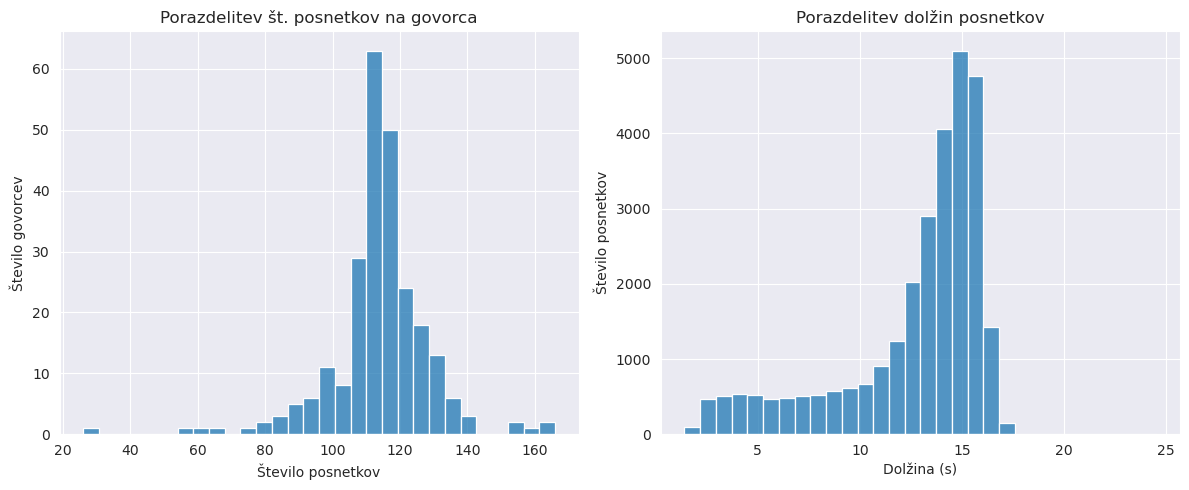

In [6]:
analyze_dataset()

In [9]:
N_SPEAKERS = 50
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_{N_SPEAKERS}.h5")
process_and_save_features(num_speakers_to_process=N_SPEAKERS)

### Vpliv števila plasti


==================== ZAČETEK EKSPERIMENTA: A1_Plasti_Simple ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_A1_Plasti_Simple.h5, nalagam ga...

Rezultati na testni množici (A1_Plasti_Simple):
  - Izguba: 3.8999
  - Natančnost: 2.24%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


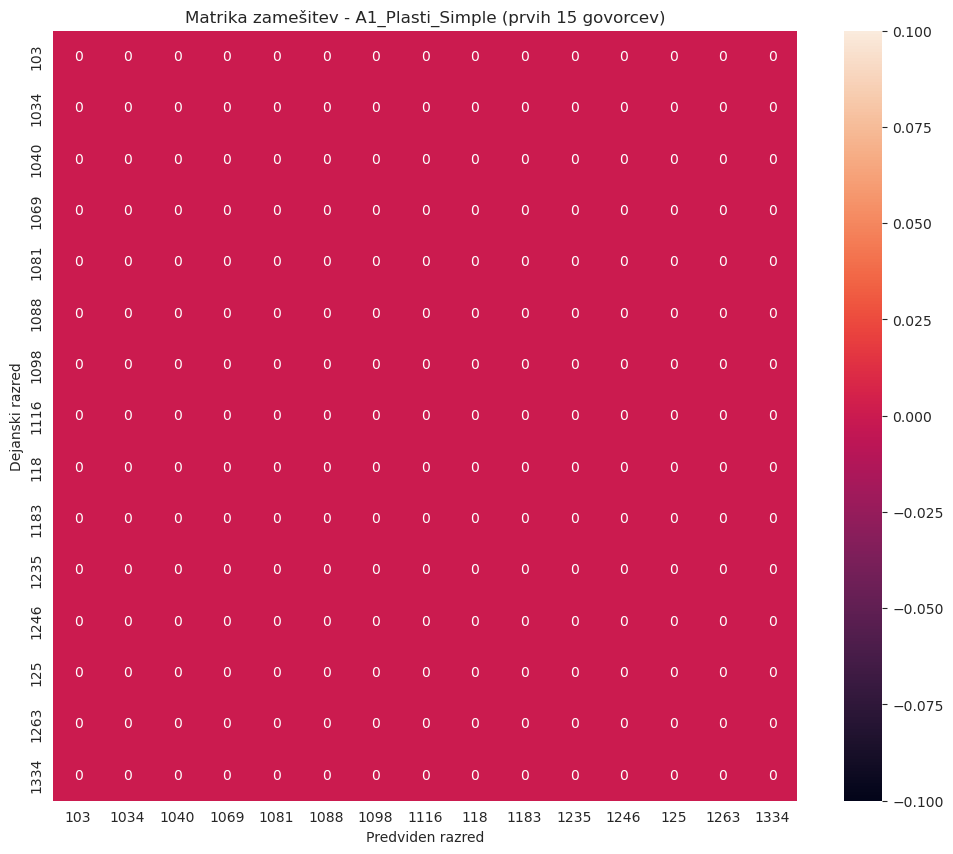


==================== ZAČETEK EKSPERIMENTA: A2_Plasti_Base ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_A2_Plasti_Base.h5, nalagam ga...

Rezultati na testni množici (A2_Plasti_Base):
  - Izguba: 0.2177
  - Natančnost: 93.72%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


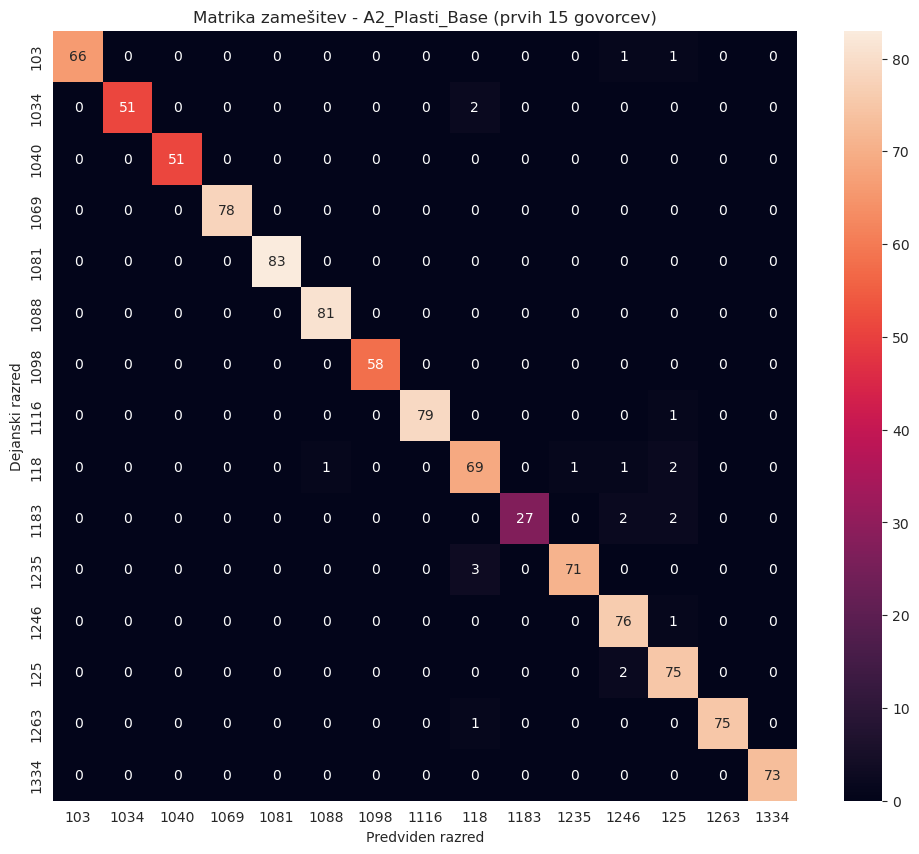


==================== ZAČETEK EKSPERIMENTA: A3_Plasti_Deep ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_A3_Plasti_Deep.h5, nalagam ga...

Rezultati na testni množici (A3_Plasti_Deep):
  - Izguba: 0.1159
  - Natančnost: 96.74%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


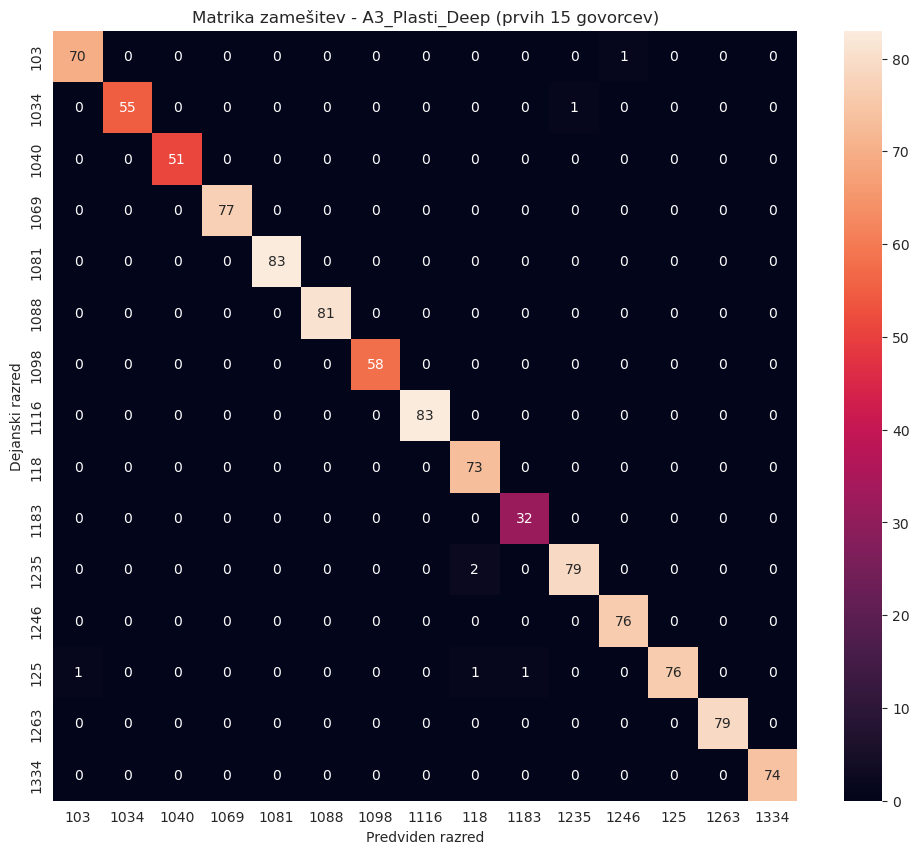

In [23]:
run_experiment("A1_Plasti_Simple", model_config={'layers_config': 'simple', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("A2_Plasti_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("A3_Plasti_Deep", model_config={'layers_config': 'deep', 'size_config': 'base'}, feature_model_path=feature_model_path)

### Vpliv velikosti plasti (na najboljši arhitekturi iz koraka A)


==================== ZAČETEK EKSPERIMENTA: B1_Velikost_Smaller ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_B1_Velikost_Smaller.h5, nalagam ga...

Rezultati na testni množici (B1_Velikost_Smaller):
  - Izguba: 3.8999
  - Natančnost: 2.24%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


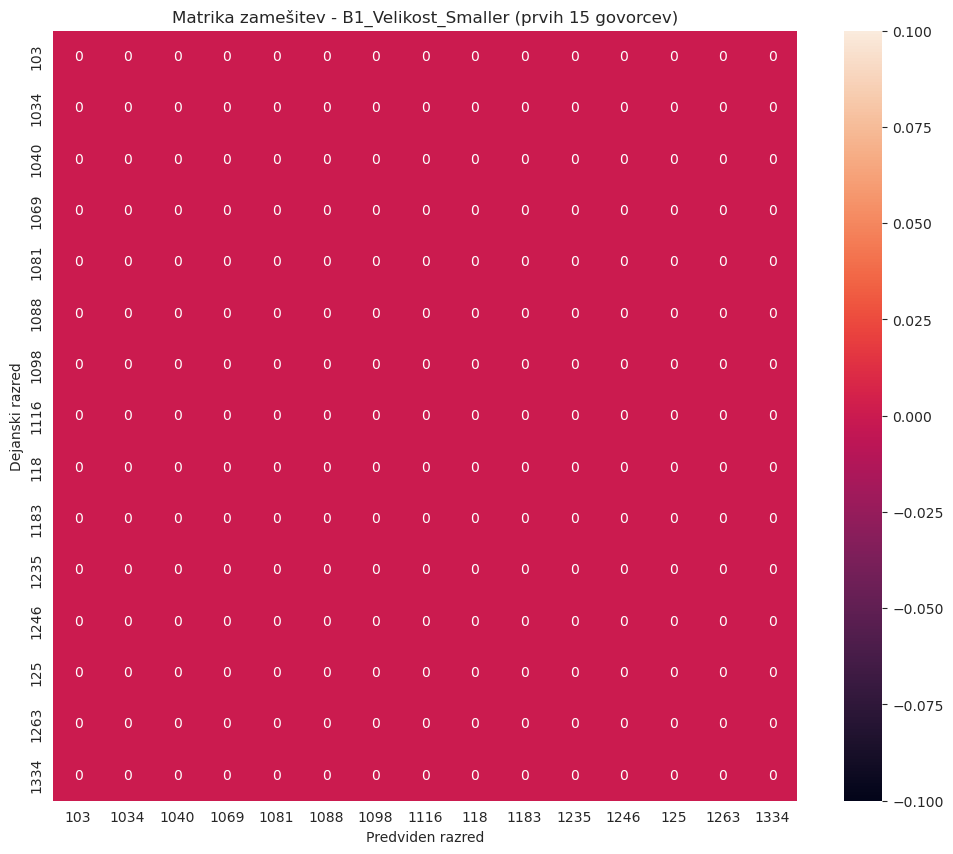


==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_B2_Velikost_Base.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.5336
  - Natančnost: 86.00%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


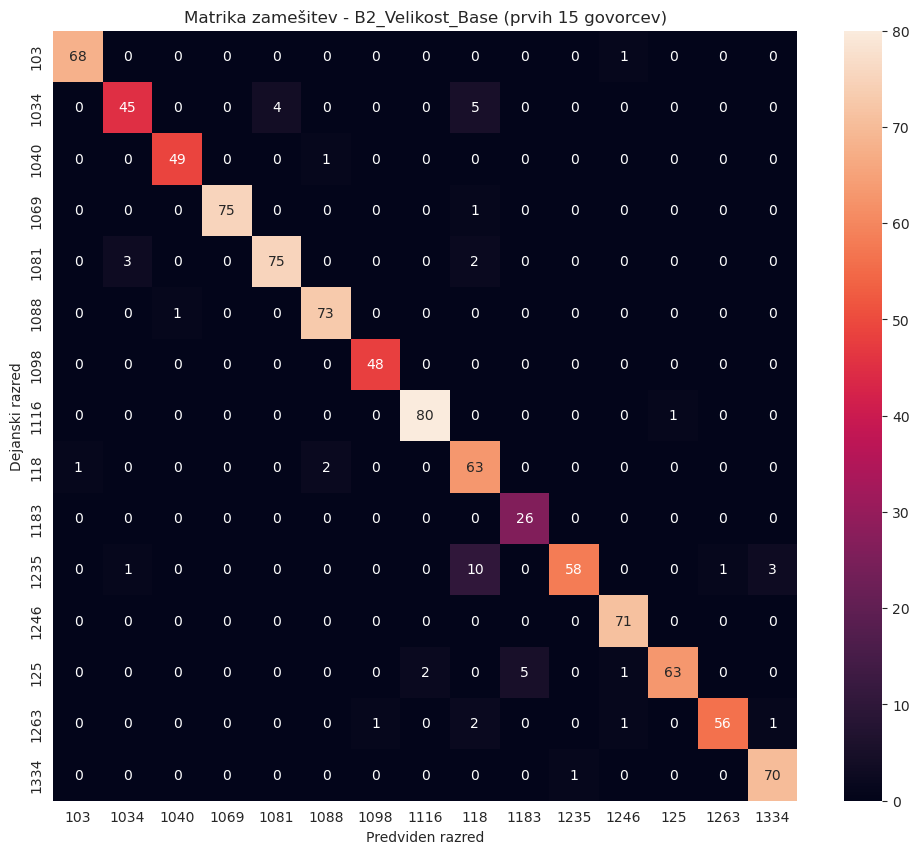


==================== ZAČETEK EKSPERIMENTA: B3_Velikost_Larger ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_B3_Velikost_Larger.h5, nalagam ga...

Rezultati na testni množici (B3_Velikost_Larger):
  - Izguba: 0.2820
  - Natančnost: 90.98%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


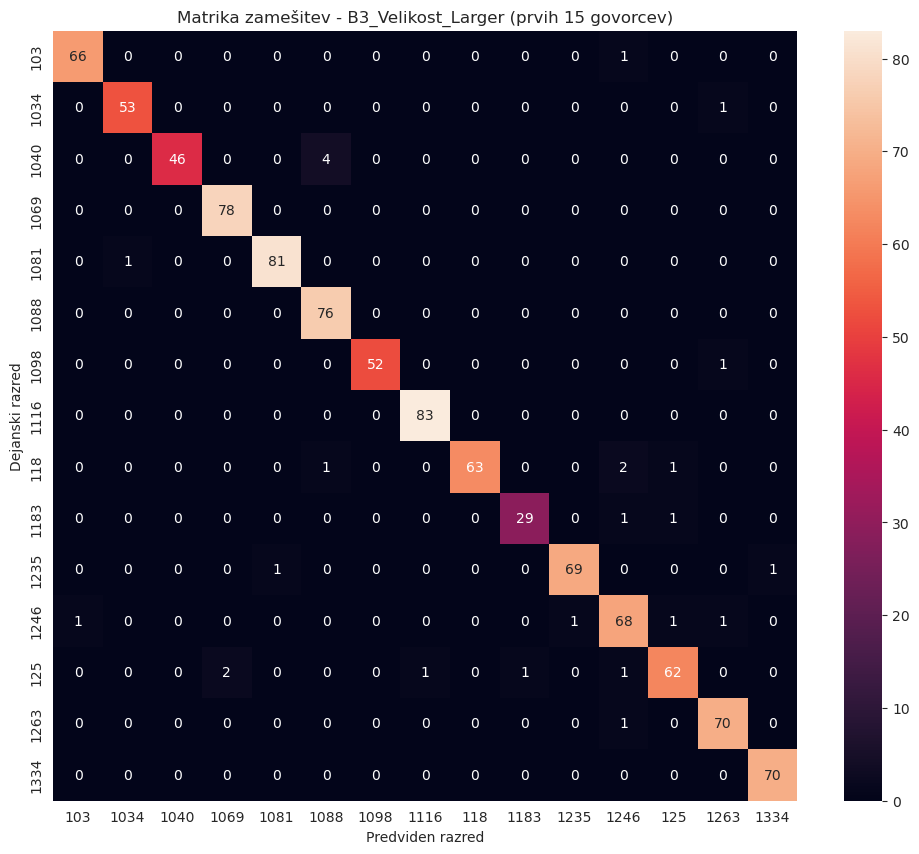

In [25]:
run_experiment("B1_Velikost_Smaller", model_config={'layers_config': 'base', 'size_config': 'smaller'}, feature_model_path=feature_model_path)
run_experiment("B2_Velikost_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("B3_Velikost_Larger", model_config={'layers_config': 'base', 'size_config': 'larger'}, feature_model_path=feature_model_path)

### Vpliv šuma (na najboljšem modelu iz koraka B)


==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_B2_Velikost_Base.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.5336
  - Natančnost: 86.00%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


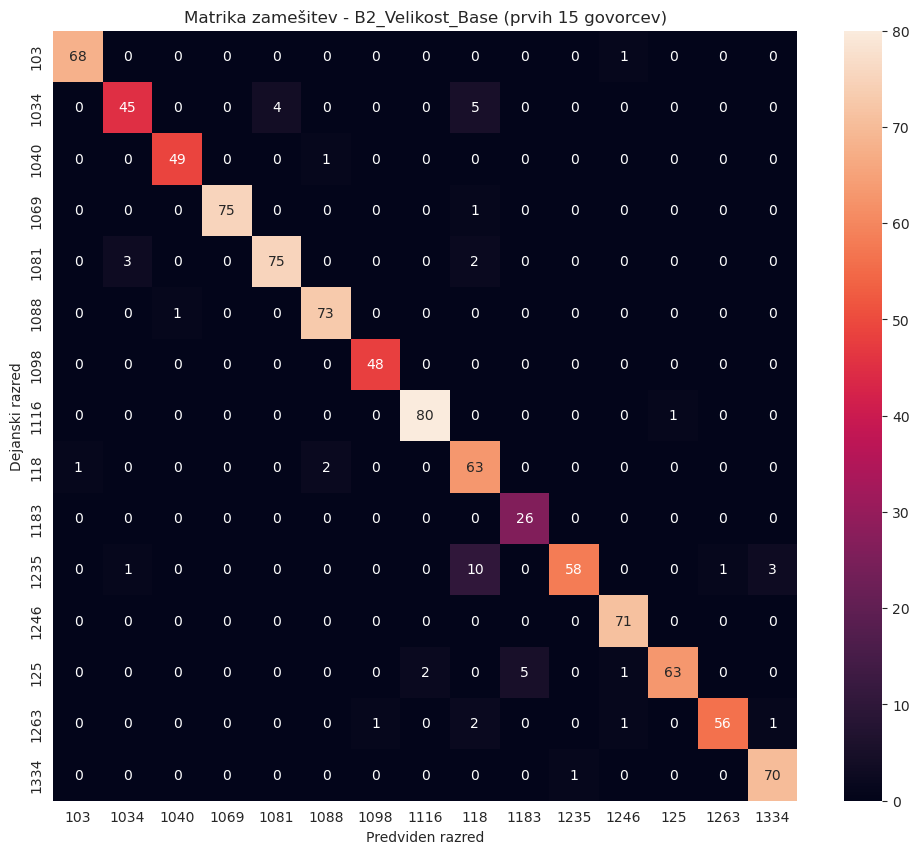


==================== ZAČETEK EKSPERIMENTA: C2_Sum_SNR20 ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_C2_Sum_SNR20.h5, nalagam ga...
Dodajam šum na testno množico: SNR = 20 dB

Rezultati na testni množici (C2_Sum_SNR20):
  - Izguba: 3.8999
  - Natančnost: 2.24%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


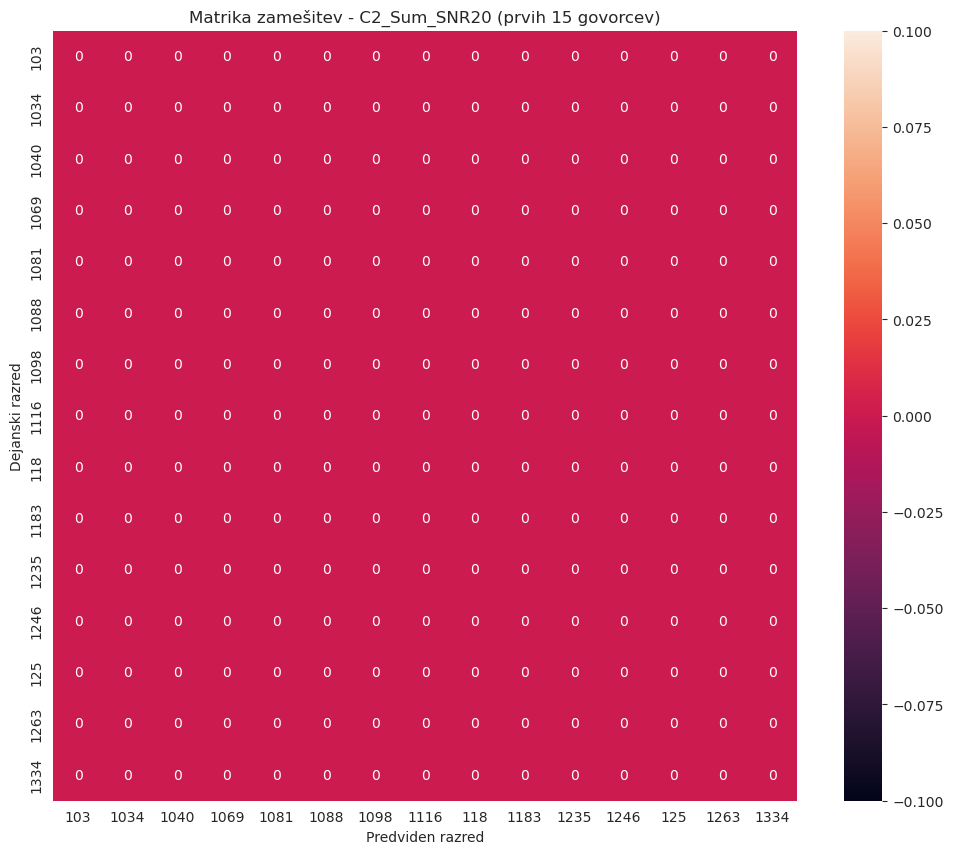


==================== ZAČETEK EKSPERIMENTA: C3_Sum_SNR10 ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_C3_Sum_SNR10.h5, nalagam ga...
Dodajam šum na testno množico: SNR = 10 dB

Rezultati na testni množici (C3_Sum_SNR10):
  - Izguba: 3.8999
  - Natančnost: 2.24%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


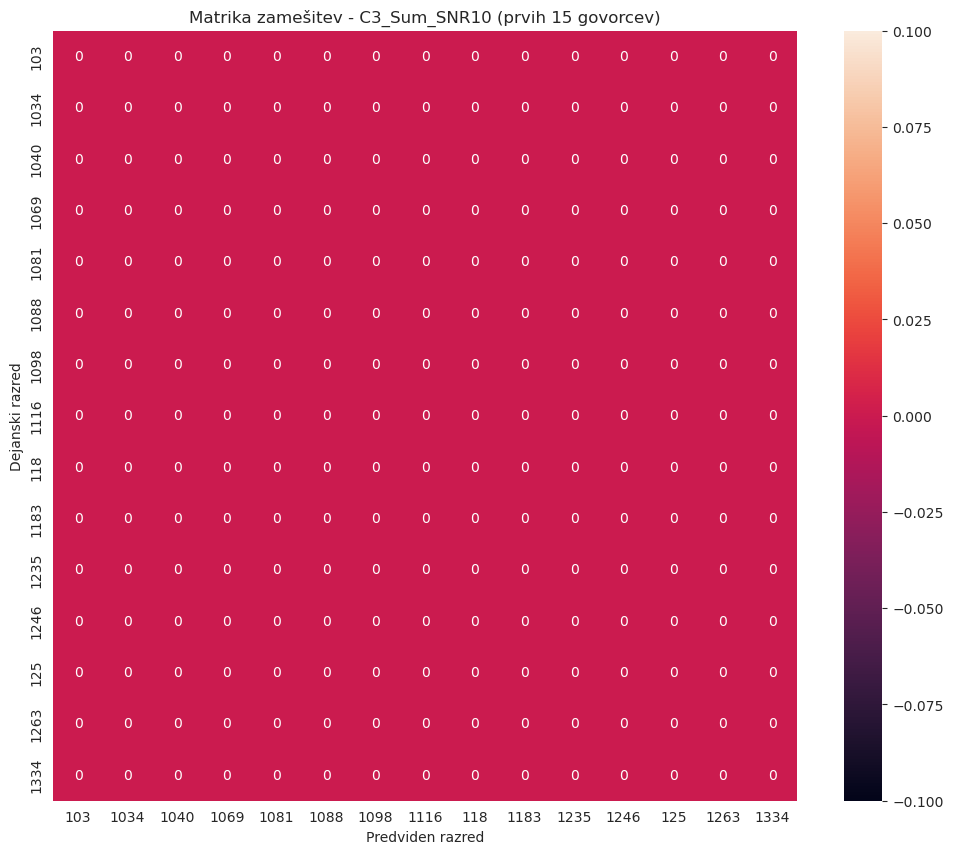


==================== ZAČETEK EKSPERIMENTA: C4_Sum_SNR0 ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_C4_Sum_SNR0.h5, nalagam ga...
Dodajam šum na testno množico: SNR = 0 dB

Rezultati na testni množici (C4_Sum_SNR0):
  - Izguba: 30.0002
  - Natančnost: 3.15%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


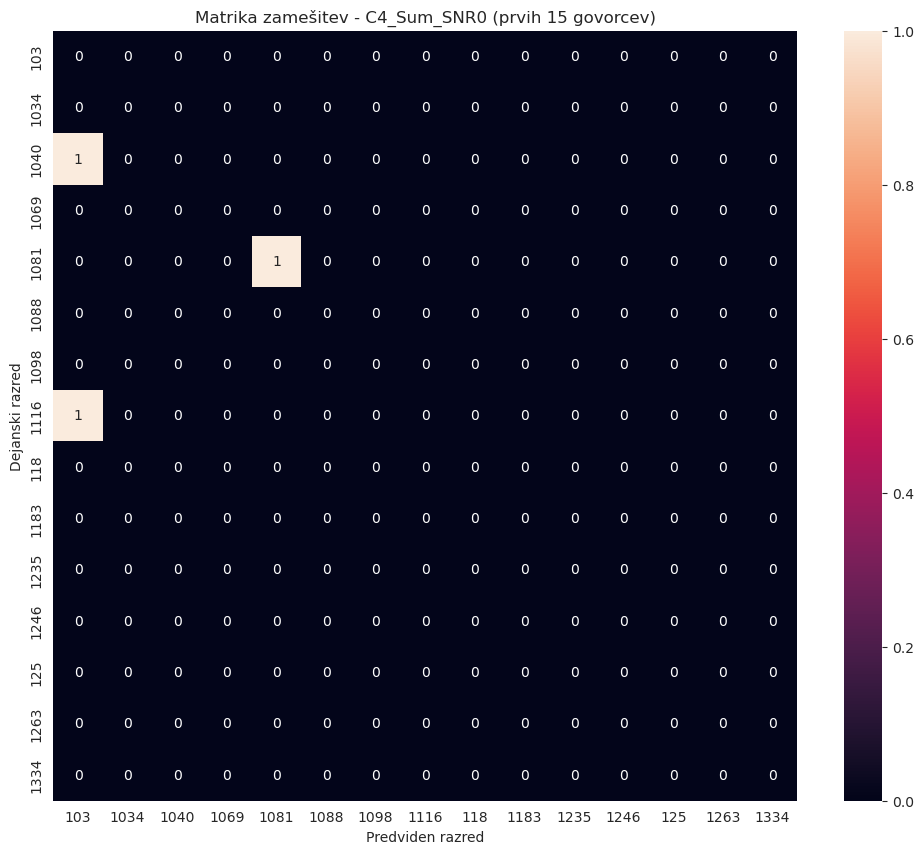

In [28]:
run_experiment("B2_Velikost_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, noise_snr=None, feature_model_path=feature_model_path)
run_experiment("C4_Sum_SNR0", model_config={'layers_config': 'base', 'size_config': 'base'}, noise_snr=0, feature_model_path=feature_model_path)

### Vpliv števila govorcev

Analiza za 50 govorcev

==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================


Velikost učne množice: 17905
Velikost validacijske množice: 3837
Velikost testne množice: 3837
Model že obstaja: best_model_B2_Velikost_Base.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.5336
  - Natančnost: 86.00%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


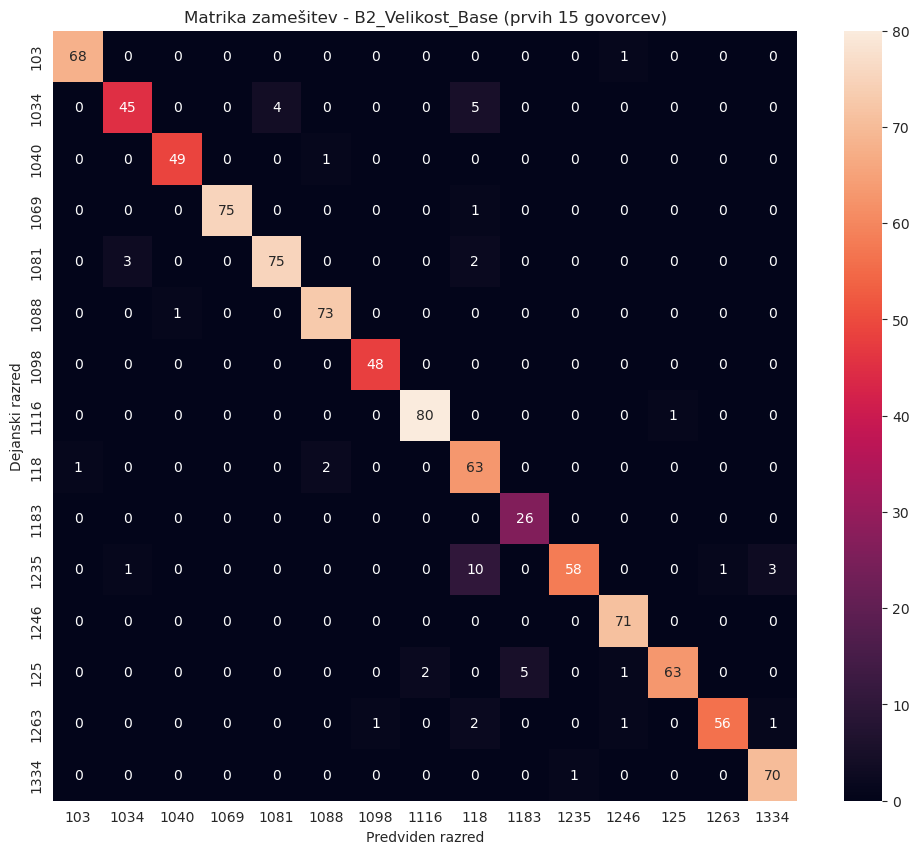

In [31]:
print("Analiza za 50 govorcev")
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_50.h5")
process_and_save_features(num_speakers_to_process=50)
run_experiment('B2_Velikost_Base', model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)

Analiza za 100 govorcev

==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base_100 ====================


Velikost učne množice: 36120
Velikost validacijske množice: 7740
Velikost testne množice: 7740
Model že obstaja: best_model_B2_Velikost_Base_100.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base_100):
  - Izguba: 0.8449
  - Natančnost: 77.91%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


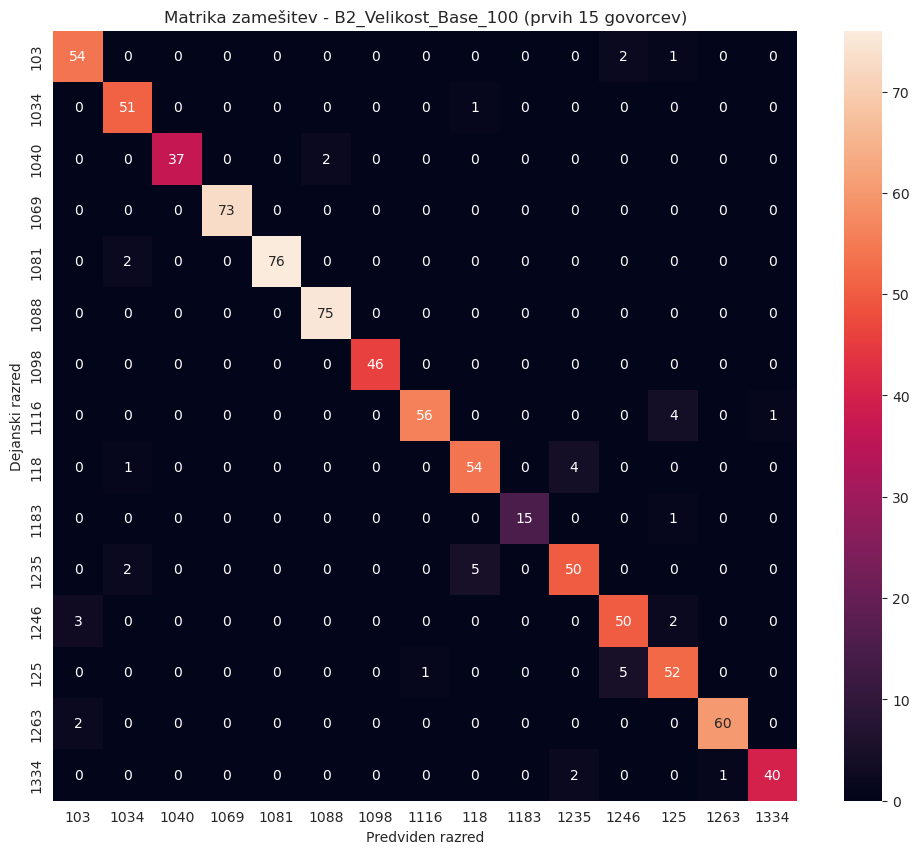

In [34]:
print("Analiza za 100 govorcev")
process_and_save_features(num_speakers_to_process=100)
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_100.h5")
run_experiment('B2_Velikost_Base_100', model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)